Importing relevant packages and modules

In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib notebook
%matplotlib inline

In [2]:
import sys
from pathlib import Path

# Plotting
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('bioAI.mplstyle')
import copy

'''
CUSTOM PACKAGES
'''
# avoid adding multiple relave paths to sys.path
sys.path.append("../src") if "../src" not in sys.path else None

from plotting_functions import *
from synthetic_grid_cells import GridModule, rotation_matrix
from methods import multiimshow, PCA_UMAP, filenames
from Experiment import Experiment
from stats import *

In [3]:
#base_path = Path("/storA/GridCells/")
base_path = "/mnt/WD12TB-HDD"
experiment = Experiment(name="gg-3ME", base_path=base_path)
experiment.setup()
paths = experiment.paths
boxsize = experiment.environments[0].boxsize
extent = [-boxsize[0] / 2, boxsize[0] / 2, -boxsize[1] / 2, boxsize[1] / 2]
f = 1/0.838#1/0.78
default = GridModule(1,orientation_offset=0, center=np.zeros(2), f=f)

Experiment <gg-3ME> already EXISTS. Loading experiment settings!
Loading experiment details
This experiment has ALREADY been setup - SKIPPING.


In [4]:
nx,ny = 2.2,2.2 # board size
boxsize=(nx,ny)
res = 200

# initialize board
xx, yy = np.meshgrid(
    np.linspace(-nx/2, nx/2, res),
    np.linspace(-ny/2, ny/2, res),
)
board = np.stack([xx, yy], axis=-1)

In [5]:
module_indices = np.load(f"{experiment.paths['experiment']}/module_indices_all_clusters.npz")
clusters = [module_indices[f] for f in module_indices.files]

torus_cells = list(clusters[2]) + list(clusters[12]) + list(clusters[15])
torus_cells.sort()
clustered_grid_cells = clusters[1]
border_cells = list(clusters[3]) + list(clusters[8])
border_cells.sort()
place_cells = clusters[10]
# include the rest of the cells in the unsorted cells (18 clusters total)
unsorted_cells = list(clusters[0]) + list(clusters[4]) + list(clusters[5]) + list(clusters[6]) + list(clusters[7]) + \
    list(clusters[9]) + list(clusters[11]) + list(clusters[13]) + list(clusters[14]) + list(clusters[16]) + list(clusters[17])
unsorted_cells.sort()
print(f"{len(torus_cells)=}, {len(clustered_grid_cells)=}, {len(border_cells)=}, {len(place_cells)=}, {len(unsorted_cells)=}")
clusters = [torus_cells, clustered_grid_cells, border_cells, place_cells, unsorted_cells]
cluster_labels = ["torus", "clustered grid", "border", "place", "unsorted"]

len(torus_cells)=604, len(clustered_grid_cells)=85, len(border_cells)=167, len(place_cells)=103, len(unsorted_cells)=2172


In [6]:
gc_scores = []
score_filenames = os.listdir(experiment.paths["grid_scores"])
for fname in score_filenames:
    if not "novel" in fname:
        with open(experiment.paths["grid_scores"] / f"{fname}", "rb") as f:
            gc_scores.append(pickle.load(f))
gc_scores = np.array(gc_scores)
# sort by sum (across environments) of scores
gcs_sorted = np.argsort(gc_scores.sum(axis=0))[::-1]

In [7]:
ratemaps = []
for env_i in range(3):
    with open(paths['ratemaps'] / (f'env_{env_i}/' + filenames(paths['ratemaps'] / f'env_{env_i}')[-1]), 'rb') as f:
        tmp_ratemaps = pickle.load(f)
        # fix nans
        tmp_ratemaps = np.array([fill_nan(ratemap, method='nearest') for ratemap in tmp_ratemaps])
        ratemaps.append(tmp_ratemaps)
ratemaps = np.stack(ratemaps)
all_ratemaps = copy.deepcopy(ratemaps)
ratemaps = ratemaps[:, torus_cells]
ncells = ratemaps.shape[1]

In [8]:
# split torus cluster into three band cell clusters
band_classes = cluster_ratemaps(ratemaps[0]) # assume ratemaps are torus ratemaps here
band_cells = [np.array(torus_cells)[band_classes == i] for i in range(3)]

100%|██████████| 604/604 [00:28<00:00, 20.84it/s]


In [9]:
#ratemaps = copy.deepcopy(all_ratemaps[:,band_cells[2]])
#ratemaps = copy.deepcopy(all_ratemaps[:,gcs_sorted[:ncells]])
ncells = ratemaps.shape[1]

(<Figure size 900x600 with 1 Axes>, <Axes: >)

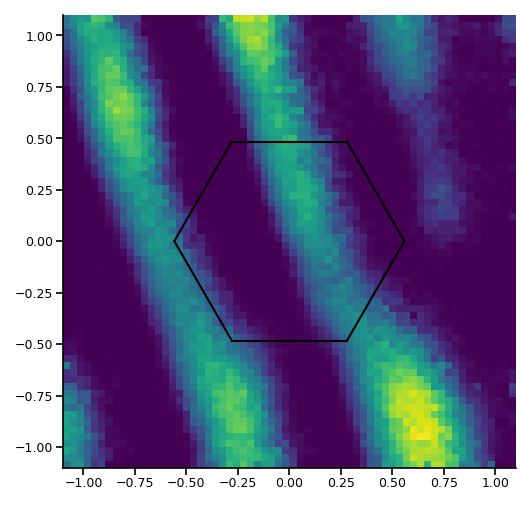

In [10]:
fig,ax = plt.subplots()
ax.imshow(ratemaps[0,0], origin="lower", extent=extent)
default.unit_cell.plot(fig,ax, color="k", linewidth=1)

(0.8031746031746032, 0.0)


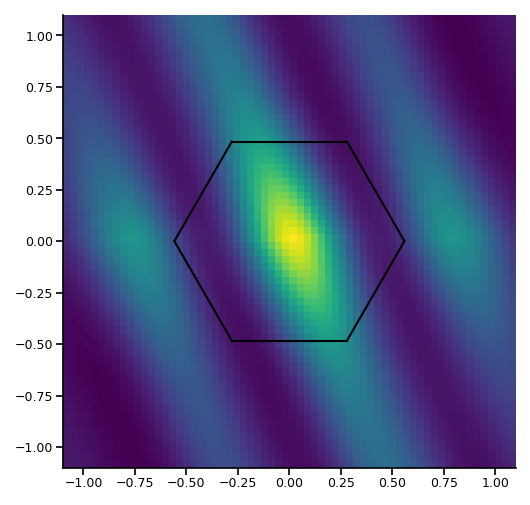

In [11]:
fig,ax = plt.subplots()
ax.imshow(correlate(ratemaps[0,0], ratemaps[0,0], mode='same'), origin="lower", extent=extent)
default.unit_cell.plot(fig,ax, color="k", linewidth=1)
print(grid_spacing(ratemaps[0,0]))

## Phase shift statistics

In [12]:
phase_shifts01 = np.array([calculate_phase_shift(ratemaps[0,i],ratemaps[1,i],boxsize=boxsize) for i in range(ncells)])
phase_shifts02 = np.array([calculate_phase_shift(ratemaps[0,i],ratemaps[2,i],boxsize=boxsize) for i in range(ncells)])
phase_shifts12 = np.array([calculate_phase_shift(ratemaps[1,i],ratemaps[2,i],boxsize=boxsize) for i in range(ncells)])
phase_shifts01 = phase_shifts01[np.isnan(phase_shifts01.sum(-1))==False]
phase_shifts02 = phase_shifts02[np.isnan(phase_shifts02.sum(-1))==False]
phase_shifts12 = phase_shifts12[np.isnan(phase_shifts12.sum(-1))==False]
print(ncells, len(phase_shifts01), len(phase_shifts02), len(phase_shifts12))

604 604 604 604


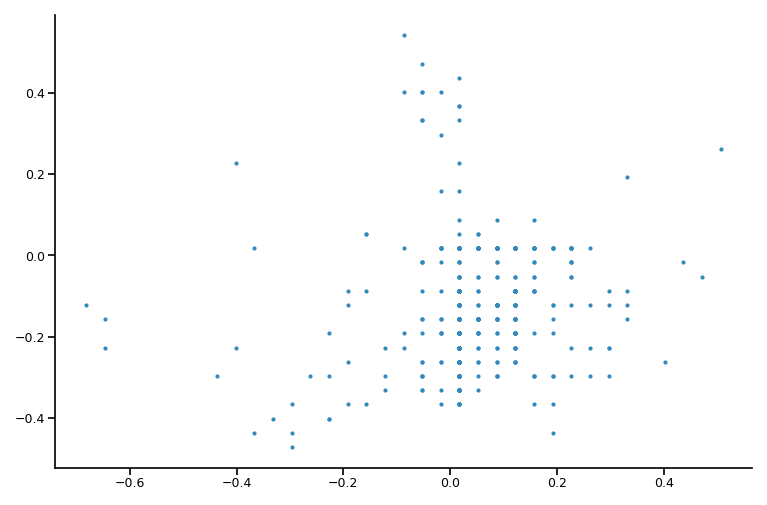

In [13]:
plt.scatter(*phase_shifts01.T, s=1)

In [14]:
from scipy.stats import gaussian_kde

bw_method = 0.1
phase_shifts01_kde = gaussian_kde(phase_shifts01.T)#, bw_method=bw_method)
phase_shifts02_kde = gaussian_kde(phase_shifts02.T)#, bw_method=bw_method)
phase_shifts12_kde = gaussian_kde(phase_shifts12.T)#, bw_method=bw_method)
phase_shifts01_map = phase_shifts01_kde(board.reshape(-1,2).T).reshape(res,res)
phase_shifts02_map = phase_shifts02_kde(board.reshape(-1,2).T).reshape(res,res)
phase_shifts12_map = phase_shifts12_kde(board.reshape(-1,2).T).reshape(res,res)
vmin,vmax = np.min([phase_shifts01_map,phase_shifts02_map,phase_shifts12_map]), np.max([phase_shifts01_map,phase_shifts02_map,phase_shifts12_map])

In [15]:
panesize = set_size(width=345, mode='tall')
figsize=(panesize[0]/3,panesize[1]/5)
figsize=(min(figsize),min(figsize))
figsize=np.array(figsize)

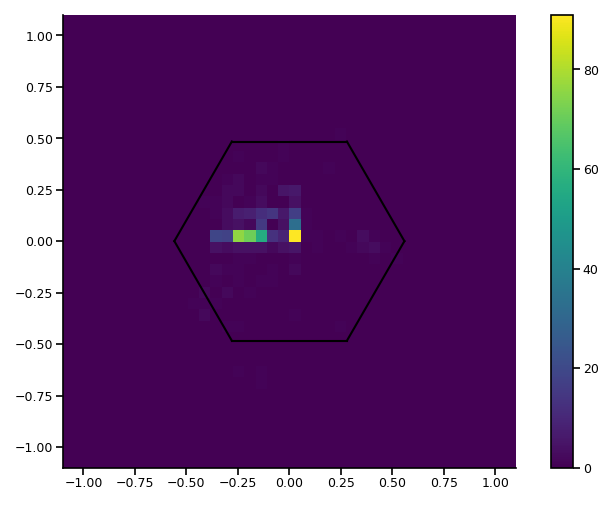

In [16]:
hist = scipy.stats.binned_statistic_2d(*phase_shifts01.T,values=np.empty_like(phase_shifts01[:,0]),
statistic="count",bins=40,range=[[-nx/2,nx/2],[-ny/2,ny/2]]).statistic

fig,ax = plt.subplots()
ax.imshow(hist, origin='lower', extent=[-nx/2,nx/2,-ny/2,ny/2])
default.unit_cell.plot(ax=ax, color='k', linewidth=1)
# add colorbar
cbar = fig.colorbar(ax.images[0], ax=ax)

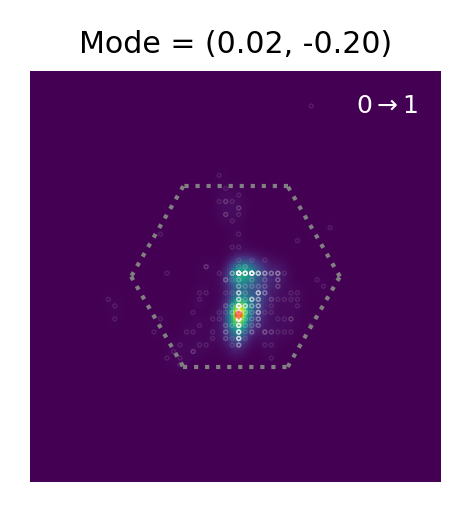

In [17]:
fig, ax = plt.subplots(figsize=figsize, dpi=300)
im = ax.imshow(phase_shifts01_map, origin='lower', extent=[-nx/2, nx/2, -ny/2, ny/2], vmin=vmin, vmax=vmax)
ax.scatter(*phase_shifts01.T, s=0.1, color='white', alpha=0.1, marker=matplotlib.markers.MarkerStyle(marker='h', fillstyle='none'))
default.unit_cell.plot(ax=ax, color='grey', linewidth=1, ls=':')
ax.axis('off')
ax.legend(["$0 \\rightarrow 1$"])
# change color of the legend to white
leg = ax.get_legend()
for text in leg.get_texts():
    text.set_color("white")

# find the mode of the distribution and plot it
mode01 = np.array(np.unravel_index(np.argmax(phase_shifts01_map, axis=None), phase_shifts01_map.shape))[::-1]
mode01 = mode01 / (np.array(phase_shifts01_map.shape[::-1]) - 1) - 0.5 # normalize to -0.5, 0.5
mode01 = mode01 * np.array([nx, ny]) # scale to the extent of the environment
ax.scatter(*mode01, s=1, color='red', alpha=0.5, marker=matplotlib.markers.MarkerStyle(marker='h', fillstyle='none'))  # plot the mode
ax.set_title(f"Mode = ({mode01[0]:.2f}, {mode01[1]:.2f})")
# remove whitespace but leave more space for title
plt.subplots_adjust(left=0, bottom=0, right=1, top=0.9, wspace=0, hspace=0)
fig.savefig(experiment.paths['experiment'] / "plots/phase_shifts01")


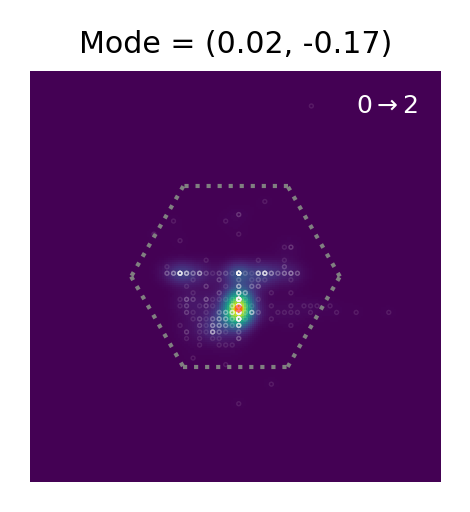

In [18]:
fig, ax = plt.subplots(figsize=figsize, dpi=300)
im = ax.imshow(phase_shifts02_map, origin='lower', extent=[-nx/2, nx/2, -ny/2, ny/2], vmin=vmin, vmax=vmax)
ax.scatter(*phase_shifts02.T, s=0.1, color='white', alpha=0.1, marker=matplotlib.markers.MarkerStyle(marker='h', fillstyle='none'))
default.unit_cell.plot(ax=ax, color='grey', linewidth=1, ls=':')
ax.axis('off')
ax.legend(["$0 \\rightarrow 2$"])
# change color of the legend to white
leg = ax.get_legend()
for text in leg.get_texts():
    text.set_color("white")

# find the mode of the distribution and plot it
mode02 = np.array(np.unravel_index(np.argmax(phase_shifts02_map, axis=None), phase_shifts02_map.shape))[::-1]
mode02 = mode02 / (np.array(phase_shifts02_map.shape[::-1]) - 1) - 0.5 # normalize to -0.5, 0.5
mode02 = mode02 * np.array([nx, ny]) # scale to the extent of the environment
ax.scatter(*mode02, s=1, color='red', alpha=0.5, marker=matplotlib.markers.MarkerStyle(marker='h', fillstyle='none'))  # plot the mode
ax.set_title(f"Mode = ({mode02[0]:.2f}, {mode02[1]:.2f})")
# remove whitespace but leave more space for title
plt.subplots_adjust(left=0, bottom=0, right=1, top=0.9, wspace=0, hspace=0)
fig.savefig(experiment.paths['experiment'] / "plots/phase_shifts02")


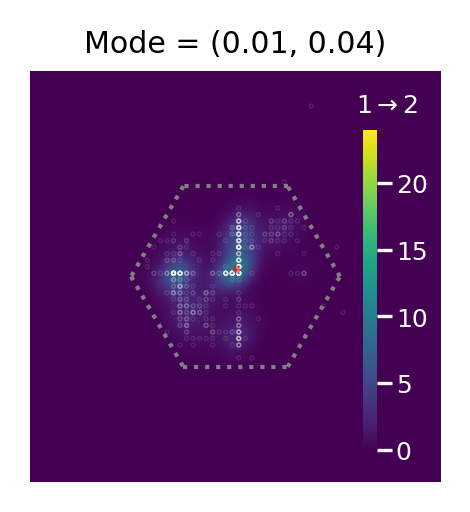

In [19]:
fig, ax = plt.subplots(figsize=figsize, dpi=300)
im = ax.imshow(phase_shifts12_map, origin='lower', extent=[-nx/2, nx/2, -ny/2, ny/2], vmin=vmin, vmax=vmax)
ax.scatter(*phase_shifts12.T, s=0.1, color='white', alpha=0.1, marker=matplotlib.markers.MarkerStyle(marker='h', fillstyle='none'))
default.unit_cell.plot(ax=ax, color='grey', linewidth=1, ls=':')
ax.axis('off')
ax.legend(["$1 \\rightarrow 2$"])
# change color of the legend to white
leg = ax.get_legend()
for text in leg.get_texts():
    text.set_color("white")

# add colorbar
cax = fig.add_axes([0.78, 0.07, 0.03, 0.7])  # adjust the position and size of the colorbar
cbar = fig.colorbar(im, cax=cax)

# remove colorbar border
cbar.outline.set_visible(False)

# change colorbar tick color
cbar.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='white')

# find the mode of the distribution and plot it
mode12 = np.array(np.unravel_index(np.argmax(phase_shifts12_map, axis=None), phase_shifts12_map.shape))[::-1]
mode12 = mode12 / (np.array(phase_shifts12_map.shape[::-1]) - 1) - 0.5 # normalize to -0.5, 0.5
mode12 = mode12 * np.array([nx, ny]) # scale to the extent of the environment
ax.scatter(*mode12, s=1, color='red', alpha=0.5, marker=matplotlib.markers.MarkerStyle(marker='h', fillstyle='none'))  # plot the mode
ax.set_title(f"Mode = ({mode12[0]:.2f}, {mode12[1]:.2f})")
# remove whitespace but leave more space for title
plt.subplots_adjust(left=0, bottom=0, right=1, top=0.9, wspace=0, hspace=0)
fig.savefig(experiment.paths['experiment'] / "plots/phase_shifts12")


## Grid Orientation statistics

In [20]:
orientations01 = np.array([calculate_orientation_shift(ratemaps[0,i], ratemaps[1,i]) for i in range(ncells)])
orientations02 = np.array([calculate_orientation_shift(ratemaps[0,i], ratemaps[2,i]) for i in range(ncells)])
orientations12 = np.array([calculate_orientation_shift(ratemaps[1,i], ratemaps[2,i]) for i in range(ncells)])
# -----------------
# make circular by extending the orientations by +- 30 degrees
#cos_calculated = np.concatenate([cos_calculated,cos_calculated+30*np.pi/180,cos_calculated-30*np.pi/180])
#ios_calculated = np.concatenate([ios_calculated,ios_calculated+30*np.pi/180,ios_calculated-30*np.pi/180])
# -----------------

-1.5041782729805093 -2.5069637883008573 -4.512534818941528
KstestResult(statistic=0.24172185430463577, pvalue=6.82938366994185e-16)
KstestResult(statistic=0.22350993377483444, pvalue=1.2487360205180572e-13)
KstestResult(statistic=0.2367549668874172, pvalue=2.948185107812826e-15)
MannwhitneyuResult(statistic=198846.0, pvalue=0.006639753414945256)
MannwhitneyuResult(statistic=229823.0, pvalue=4.8915877721850775e-15)
MannwhitneyuResult(statistic=223981.0, pvalue=6.609611163015805e-12)
WilcoxonResult(statistic=56281.0, pvalue=4.238301261688922e-12)
WilcoxonResult(statistic=56353.0, pvalue=1.0007085460024384e-13)
WilcoxonResult(statistic=60443.0, pvalue=1.8616578479399591e-09)
Ttest_indResult(statistic=0.81658392627041, pvalue=0.4143275113035777)
Ttest_indResult(statistic=6.294175597614131, pvalue=4.317497837146286e-10)
Ttest_indResult(statistic=6.264142242338089, pvalue=5.205445814202598e-10)


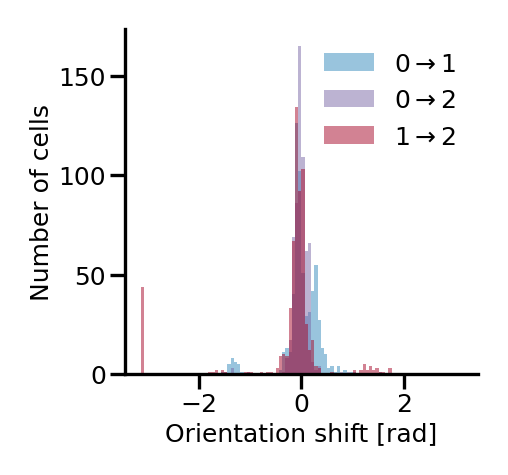

In [21]:
fig, ax = plt.subplots(figsize=figsize, dpi=300)
ax.hist(orientations01, bins=100, alpha=0.5, label='$0\\rightarrow 1$', range=[-np.pi,np.pi])
ax.hist(orientations02, bins=100, alpha=0.5, label='$0\\rightarrow 2$', range=[-np.pi,np.pi])
ax.hist(orientations12, bins=100, alpha=0.5, label='$1\\rightarrow 2$', range=[-np.pi,np.pi])
ax.legend()
ax.set_xlabel('Orientation shift [rad]')
ax.set_ylabel('Number of cells')

fig.savefig(experiment.paths['experiment'] / "plots/orientation_shifts", bbox_inches='tight')

from scipy.stats import kstest, mannwhitneyu, wilcoxon, ttest_ind
print(np.nanmedian(orientations01)*180/np.pi, np.nanmedian(orientations02)*180/np.pi, np.nanmedian(orientations12)*180/np.pi)
print(kstest(orientations01, orientations02))
print(kstest(orientations01, orientations12))
print(kstest(orientations02, orientations12))
print(mannwhitneyu(orientations01, orientations02))
print(mannwhitneyu(orientations01, orientations12))
print(mannwhitneyu(orientations02, orientations12))
print(wilcoxon(orientations01, orientations02))
print(wilcoxon(orientations01, orientations12))
print(wilcoxon(orientations02, orientations12))
print(ttest_ind(orientations01, orientations02))
print(ttest_ind(orientations01, orientations12))
print(ttest_ind(orientations02, orientations12))

In [22]:
# circularize the orientations
orientations01_circular = ((copy.deepcopy(orientations01) + np.pi/12) % (np.pi/6)) - np.pi/12
orientations02_circular = ((copy.deepcopy(orientations02) + np.pi/12) % (np.pi/6)) - np.pi/12
orientations12_circular = ((copy.deepcopy(orientations12) + np.pi/12) % (np.pi/6)) - np.pi/12
orientations01_circular = np.concatenate([orientations01_circular, orientations01_circular+np.pi/6, orientations01_circular-np.pi/6])
orientations02_circular = np.concatenate([orientations02_circular, orientations02_circular+np.pi/6, orientations02_circular-np.pi/6])
orientations12_circular = np.concatenate([orientations12_circular, orientations12_circular+np.pi/6, orientations12_circular-np.pi/6])

-2.9665738161560142 -2.5069637883008573 -2.5069637883008573
-1.3784150233356267 -0.8391134313490548 -1.8445276614584467
8.10222090471566 6.165379886249438 6.329394084742792
0.3296746931336013 0.2508657497684818 0.2575393928589065
KstestResult(statistic=0.16556291390728478, pvalue=1.2121082543511626e-07)
KstestResult(statistic=0.11754966887417219, pvalue=0.0004688377212851146)
KstestResult(statistic=0.13245033112582782, pvalue=4.8924342558388856e-05)
MannwhitneyuResult(statistic=167572.0, pvalue=0.014291684753000598)
MannwhitneyuResult(statistic=182890.0, pvalue=0.936625998430426)
MannwhitneyuResult(statistic=201353.0, pvalue=0.001755494208083922)
WilcoxonResult(statistic=82079.5, pvalue=0.5915825868347716)
WilcoxonResult(statistic=85577.5, pvalue=0.7001769864897518)
WilcoxonResult(statistic=77659.5, pvalue=0.0773397239682233)
Ttest_indResult(statistic=-1.3007360307184475, pvalue=0.19359730623830373)
Ttest_indResult(statistic=1.113261584582993, pvalue=0.2658179375787037)
Ttest_indResult

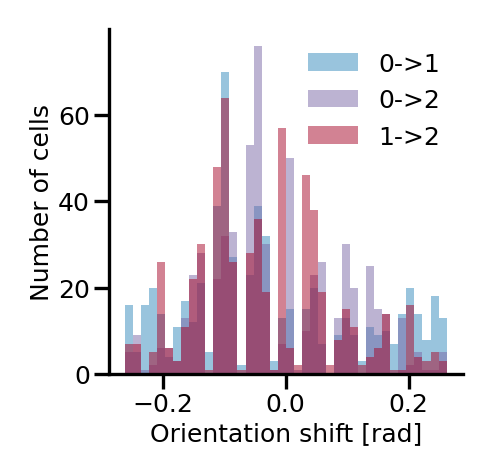

In [23]:
fig, ax = plt.subplots(figsize=figsize, dpi=300)

ax.hist(orientations01_circular, bins=40, alpha=0.5, label='0->1', range=(-np.pi/12,np.pi/12))
ax.hist(orientations02_circular, bins=40, alpha=0.5, label='0->2', range=(-np.pi/12,np.pi/12))
ax.hist(orientations12_circular, bins=40, alpha=0.5, label='1->2', range=(-np.pi/12,np.pi/12))
ax.legend()
mask01 = (orientations01_circular > -np.pi/12) & (orientations01_circular < np.pi/12)
mask02 = (orientations02_circular > -np.pi/12) & (orientations02_circular < np.pi/12)
mask12 = (orientations12_circular > -np.pi/12) & (orientations12_circular < np.pi/12)
print(np.nanmedian(orientations01_circular[mask01])*180/np.pi, np.nanmedian(orientations02_circular[mask02])*180/np.pi, np.nanmedian(orientations12_circular[mask12])*180/np.pi)
#ax.axvline(np.nanmedian(orientations01_circular[mask01]),ls='--')
#ax.axvline(np.nanmedian(orientations02_circular[mask02]),ls='--')
#ax.axvline(np.nanmedian(orientations12_circular[mask12]),ls='--')
ax.set_xlabel('Orientation shift [rad]')
ax.set_ylabel('Number of cells')

fig.savefig(experiment.paths['experiment'] / "plots/orientation_shifts_circular", bbox_inches='tight')

# compute mean and standard deviation in degrees
print(np.nanmean(orientations01_circular[mask01])*180/np.pi, np.nanmean(orientations02_circular[mask02])*180/np.pi, np.nanmean(orientations12_circular[mask12])*180/np.pi)
print(np.nanstd(orientations01_circular[mask01])*180/np.pi, np.nanstd(orientations02_circular[mask02])*180/np.pi, np.nanstd(orientations12_circular[mask12])*180/np.pi)

# compute standard error of the mean in degrees
print(np.nanstd(orientations01_circular[mask01])/np.sqrt(np.sum(mask01))*180/np.pi, np.nanstd(orientations02_circular[mask02])/np.sqrt(np.sum(mask02))*180/np.pi, np.nanstd(orientations12_circular[mask12])/np.sqrt(np.sum(mask12))*180/np.pi)

print(kstest(orientations01_circular[mask01], orientations02_circular[mask02]))
print(kstest(orientations01_circular[mask01], orientations12_circular[mask12]))
print(kstest(orientations02_circular[mask02], orientations12_circular[mask12]))
print(mannwhitneyu(orientations01_circular[mask01], orientations02_circular[mask02]))
print(mannwhitneyu(orientations01_circular[mask01], orientations12_circular[mask12]))
print(mannwhitneyu(orientations02_circular[mask02], orientations12_circular[mask12]))
print(wilcoxon(orientations01_circular[mask01], orientations02_circular[mask02]))
print(wilcoxon(orientations01_circular[mask01], orientations12_circular[mask12]))
print(wilcoxon(orientations02_circular[mask02], orientations12_circular[mask12]))
print(ttest_ind(orientations01_circular[mask01], orientations02_circular[mask02]))
print(ttest_ind(orientations01_circular[mask01], orientations12_circular[mask12]))
print(ttest_ind(orientations02_circular[mask02], orientations12_circular[mask12]))

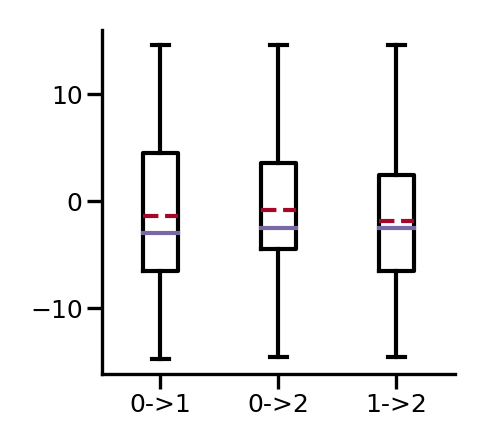

In [24]:
# create boxplot of orientation shifts
fig, ax = plt.subplots(figsize=figsize, dpi=300)
results = plt.boxplot([orientations01_circular[mask01]*180/np.pi, orientations02_circular[mask02]*180/np.pi, 
             orientations12_circular[mask12]*180/np.pi], labels=['0->1', '0->2', '1->2'], meanline=True, showmeans=True);

0.33426183844008633
-0.6829174009436815
8.556646938097103
0.24447562680277438


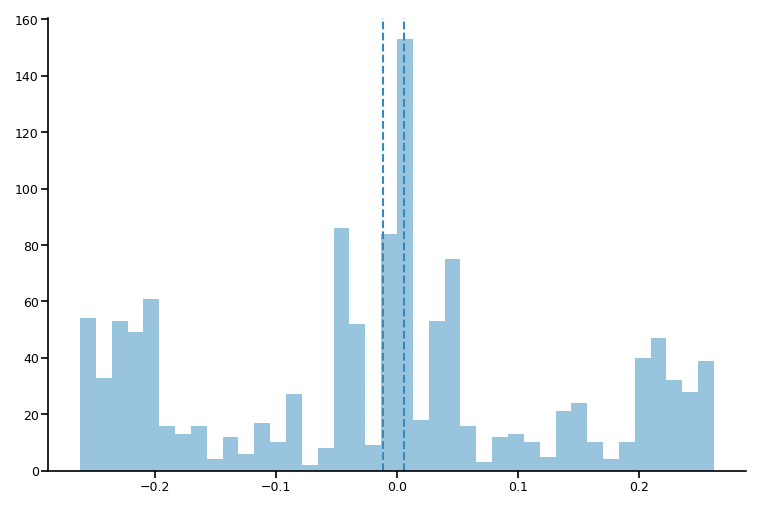

In [25]:
# compute orientation shifts between cells in the same environment (to confirm that the shif statistic is not biased)
orietations_between_cells01 = np.array([calculate_orientation_shift(ratemaps[0,i], ratemaps[0,j]) for i in range(40) for j in range(i+1,50)])

orietations_between_cells01_circular = orietations_between_cells01 % (np.pi/6)
orietations_between_cells01_circular = np.concatenate([orietations_between_cells01_circular, orietations_between_cells01_circular+np.pi/6, orietations_between_cells01_circular-np.pi/6])

plt.hist(orietations_between_cells01_circular, bins=40, alpha=0.5, label='0->1', range=(-np.pi/12,np.pi/12))
maskbetween01 = (orietations_between_cells01_circular > -np.pi/12) & (orietations_between_cells01_circular < np.pi/12)
print(np.nanmedian(orietations_between_cells01_circular[maskbetween01])*180/np.pi)
print(np.nanmean(orietations_between_cells01_circular[maskbetween01])*180/np.pi)
print(np.nanstd(orietations_between_cells01_circular[maskbetween01])*180/np.pi)
print(np.nanstd(orietations_between_cells01_circular[maskbetween01])/np.sqrt(np.sum(maskbetween01))*180/np.pi)
plt.axvline(np.nanmedian(orietations_between_cells01_circular[maskbetween01]),ls='--')
plt.axvline(np.nanmean(orietations_between_cells01_circular[maskbetween01]),ls='--')

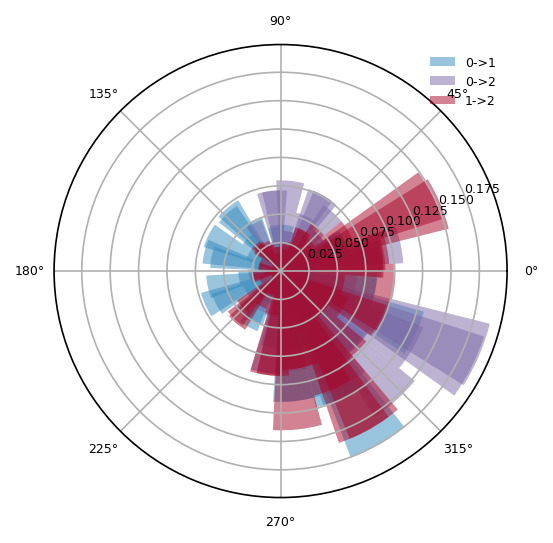

In [26]:
fig,ax = plt.subplots(subplot_kw={'projection':'polar'})
ax.hist(orientations01_circular*12, bins=60, density=True, alpha=0.5, label='0->1')
ax.hist(orientations02_circular*12, bins=60, density=True, alpha=0.5, label='0->2')
ax.hist(orientations12_circular*12, bins=60, density=True, alpha=0.5, label='1->2')
ax.legend()

## Calculate spacing

In [27]:
spacings = np.zeros(ratemaps.shape[:2])
for i in range(ratemaps.shape[0]):
    for j in range(ratemaps.shape[1]):
        spacings[i,j] = grid_spacing(ratemaps[i,j])[0]
print(np.isnan(spacings).sum())

1


[0.84262112 0.82830817 0.83809524] 0.8380952380952381


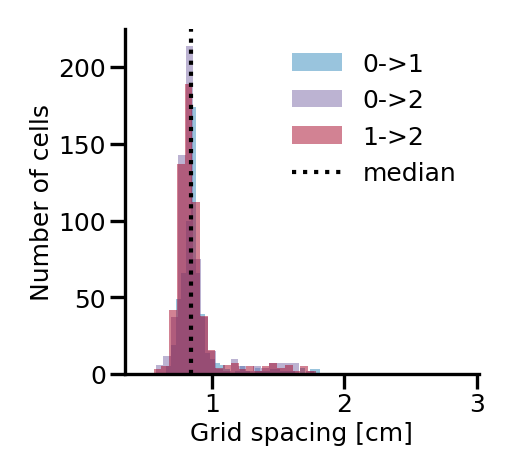

In [28]:
fig, ax = plt.subplots(figsize=figsize, dpi=300)
ax.hist(spacings[0], bins=40, alpha=0.5, label='0->1')
ax.hist(spacings[1], bins=40, alpha=0.5, label='0->2')
ax.hist(spacings[2], bins=40, alpha=0.5, label='1->2')
ax.axvline(np.nanmedian(spacings), color='k', ls=':', label='median')
ax.legend()
ax.set_xlabel('Grid spacing [cm]')
ax.set_ylabel('Number of cells')
print(np.nanmedian(spacings,axis=1), np.nanmedian(spacings))
fig.savefig(experiment.paths['experiment'] / "plots/grid_spacing", bbox_inches='tight')

In [29]:
np.sqrt(64)

8.0

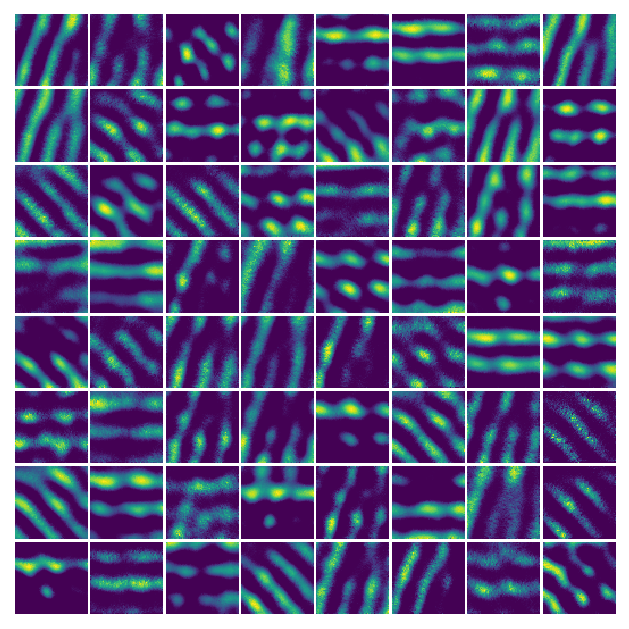

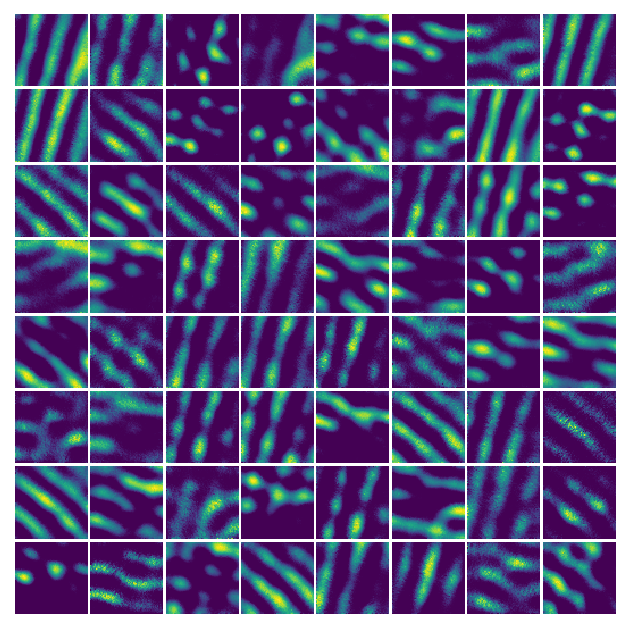

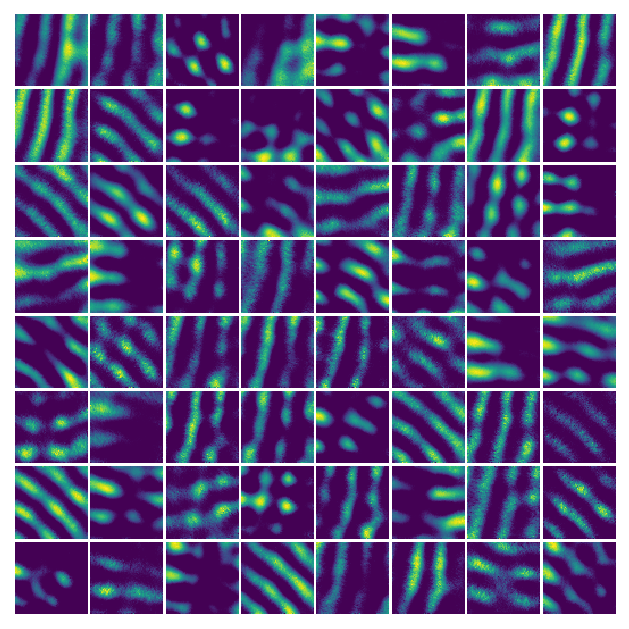

In [30]:
from methods import multiimshow2
for env_i in range(3):
    fig, axs = multiimshow2(ratemaps[env_i,:64], normalize=False, figsize=(4,4), rect=(0,0,1,1), axes_pad=0.02)
    fig.savefig(experiment.paths['experiment'] / f"plots/hgcs_ratemaps_{env_i}")